In [1]:
# installing  necessery libraries
!pip install arabert
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186458 sha256=8dc2ad165e9a080f515303c3c75fdfda402e9639abbe9087aaae9fef38fd4d3f
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.8 MB/s eta 0:00:00


In [2]:
# import necessery libraries
import pandas as pd
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Check device name
print(torch.cuda.get_device_name(0))

Tesla T4


In [5]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the DataFrame with the poem data
df = pd.read_csv('poems.csv')  # Replace 'data(2).csv' with your actual dataset file

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Define the features and target variable
features = ['poem_content']
target = 'poet_name'

# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")

# Load the ArabertPreprocessor
preprocessor = ArabertPreprocessor("aubmindlab/bert-base-arabertv2")

# Preprocess the poem texts using ArabertPreprocessor
train_texts = list(train_df[features[0]])
test_texts = list(test_df[features[0]])

preprocessed_train_texts = [preprocessor.preprocess(text) for text in train_texts]
preprocessed_test_texts = [preprocessor.preprocess(text) for text in test_texts]

# Tokenize the preprocessed poem texts
train_encodings = tokenizer(preprocessed_train_texts, truncation=True, padding=True)
test_encodings = tokenizer(preprocessed_test_texts, truncation=True, padding=True)

# Encode the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df[target])
test_labels = label_encoder.transform(test_df[target])

# Move data to GPU
train_encodings = {key: torch.tensor(value).to(device) for key, value in train_encodings.items()}
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
test_encodings = {key: torch.tensor(value).to(device) for key, value in test_encodings.items()}
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

# Define the model architecture
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv2', num_labels=5)
model.to(device)

# Set up the training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
train_dataset = list(zip(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels))
test_dataset = list(zip(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels))

# Train the model
for epoch in range(5):  # Set the desired number of training epochs
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_dataset:
        optimizer.zero_grad()
        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        labels = labels.unsqueeze(0).to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}: Average Loss: {total_loss / len(train_dataset)}")

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


100%|██████████| 241M/241M [00:40<00:00, 5.89MiB/s]


[2023-07-07 18:14:10,073 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base

Epoch 1: Average Loss: 0.8536180931604482
Epoch 2: Average Loss: 0.40155345648728263
Epoch 3: Average Loss: 0.20153370117490177
Epoch 4: Average Loss: 0.10993728096862988
Epoch 5: Average Loss: 0.0833749085572313


Accuracy: 0.8140975987606507
Classification Report:
                    precision    recall  f1-score   support

         أحمد شوقي       0.92      0.78      0.84       225
           البحتري       0.66      0.92      0.76       286
           الفرزدق       0.87      0.93      0.90       253
   صفي الدين الحلي       0.82      0.55      0.66       267
محيي الدين بن عربي       0.92      0.88      0.90       260

          accuracy                           0.81      1291
         macro avg       0.84      0.81      0.81      1291
      weighted avg       0.83      0.81      0.81      1291



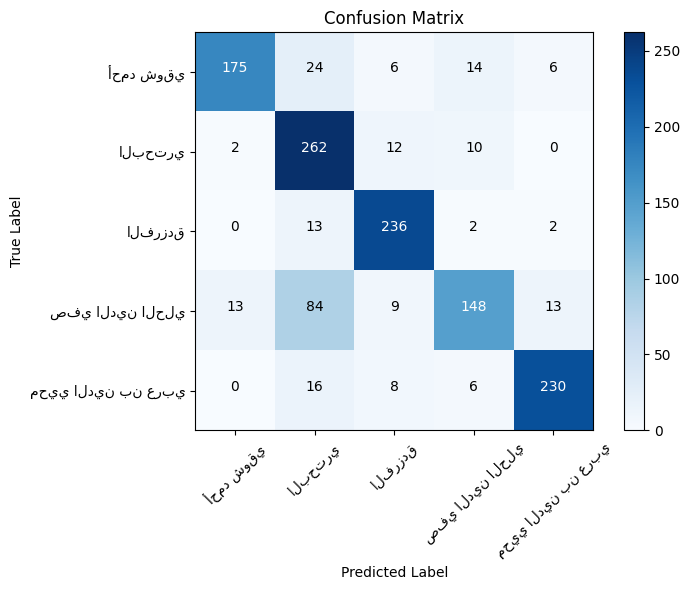

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
model.eval()
total_correct = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataset:
        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(dim=1)

        predicted_labels.extend(predictions.tolist())  # Collect predicted labels
        true_labels.extend([labels.item()])  # Collect true labels as a list

        total_correct += int(predictions == labels)

# Calculate accuracy
accuracy = total_correct / len(test_dataset)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, F1 score, and support
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
fmt = '.2f' if cm.dtype == 'float' else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()